# script: Reads the raw files and use several methods to interpolate the photometry data

The idea is to use interpolation methods in python to deal with the difference of sampling rate between the photometry and freezing data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, ConfusionMatrixDisplay
from scipy import interpolate
from scipy import signal
from scipy import stats

Define the path where the files are adn where the new ones will be saved

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = path='/Users/MarenLab/FP/Model/'
display(path)

'/content/drive/MyDrive/Dados/Flavitcho/'

Read the data into a pandas dataframe.

Note that NaN values can be removed easily

In [ ]:
activity = pd.read_csv(path+'Exposure_raw_activity.raw.csv')
dFF_traces = pd.read_csv(path+'Photometry_DeltaF_traces.csv')
freezing = pd.read_csv(path+'freezing.csv')
activity = activity.dropna()
dFF_traces = dFF_traces.dropna()

In what follows the photometry and freezing data are displayed.

Note that the *sampling time* is different and we need to interpolate the photometry data to bale to analyse whether the freezing is somehow as consequence of the photometry. To this end, we will use splines.


In [ ]:
display(activity)

,Time,SP1,SP2,SP3,SP4,SP5,SP6,SP7,MT3,MT7,MT8
0,0.033333,226.0,1019.0,582.0,240.0,132.0,449.0,832.0,121,1540,75
1,0.066667,183.0,1517.0,594.0,269.0,347.0,657.0,624.0,154,2053,49
2,0.100000,240.0,1362.0,751.0,164.0,588.0,798.0,423.0,512,2006,33
3,0.133333,295.0,1700.0,757.0,69.0,650.0,955.0,398.0,559,1486,0
4,0.166667,143.0,1980.0,515.0,104.0,603.0,1003.0,239.0,619,1575,13
...,...,...,...,...,...,...,...,...,...,...,...
35995,1199.866676,27.0,23.0,1.0,27.0,700.0,54.0,0.0,0,998,575
35996,1199.900010,27.0,20.0,0.0,0.0,445.0,4.0,0.0,2,1189,444
35997,1199.933343,3.0,15.0,0.0,14.0,615.0,1.0,0.0,0,892,64
35998,1199.966676,2.0,18.0,0.0,27.0,794.0,94.0,26.0,0,678,296


In [ ]:
display(dFF_traces)

,Time,SP1,SP2,SP3,SP4,SP5,SP6,MT3,MT7,MT8
0,0.05,1.401444,2.838161,1.820027,2.897541,14.898166,-0.568573,0.837651,5.118783,6.384591
1,0.10,1.481676,2.991608,1.825564,2.848034,14.845276,-0.520420,0.847389,5.056940,6.337633
2,0.15,1.559757,3.142909,1.830623,2.798912,14.792029,-0.473017,0.857040,4.996460,6.289506
3,0.20,1.635571,3.291907,1.835179,2.750119,14.738411,-0.426469,0.866610,4.937365,6.240209
4,0.25,1.709016,3.438475,1.839214,2.701566,14.684387,-0.380885,0.876104,4.879671,6.189754
...,...,...,...,...,...,...,...,...,...,...
24268,1213.45,-1.739407,-0.851923,0.887859,-1.499511,6.691424,3.496687,0.180727,2.594341,-0.562271
24269,1213.50,-1.744207,-0.728657,0.882818,-1.515892,6.696953,3.497644,0.111242,2.864197,-0.601487
24270,1213.55,-1.748572,-0.606904,0.877451,-1.533193,6.696384,3.498239,0.045707,3.134790,-0.640635
24271,1213.60,-1.752144,-0.487721,0.871808,-1.551219,6.688659,3.498502,-0.015296,3.404967,-0.679796


In [ ]:
display(freezing)

,Time,SP1,SP2,SP3,SP4,SP5,SP6,MT3,MT7,MT8
0,0.033333,0,0,0,0,0,0,0,0,0
1,0.066667,0,0,0,0,0,0,0,0,0
2,0.100000,0,0,0,0,0,0,0,0,0
3,0.133333,0,0,0,0,0,0,0,0,0
4,0.166667,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
35995,1199.866676,1,0,1,0,0,0,1,0,0
35996,1199.900010,1,0,1,0,0,0,1,0,0
35997,1199.933343,1,0,1,0,0,0,1,0,0
35998,1199.966676,1,0,1,0,0,0,1,0,0


First of all we need to create a new pandas dataframe for the photometry with the same columns as the original dataframe.

In [ ]:
cols = dFF_traces.columns
display(cols)

Index(['Time', 'SP1', 'SP2', 'SP3', 'SP4', 'SP5', 'SP6', 'MT3', 'MT7', 'MT8'], dtype='object')

In [ ]:
new_dFF_traces = pd.DataFrame(columns=cols)
new_dFF_traces_der = pd.DataFrame(columns=cols)  # The derivative of the photometry data
new_dFF_traces_det = pd.DataFrame(columns=cols)  # Detrended signal
new_dFF_traces_sg = pd.DataFrame(columns=cols)  # Apply a Savitzky-Golay filter to the photometry data
new_dFF_traces_sg_der = pd.DataFrame(columns=cols)  # Apply a Savitzky-Golay filter to the photometry data and use the derivative
new_dFF_traces_sg_fl = pd.DataFrame(columns=cols)  # Residues from comparing photometry data and the result of applying Savitzky-Golay filter
new_dFF_traces_zs = pd.DataFrame(columns=cols)   # Photometry normalized as Totty did

Now we are ready to use the package spline imported from the library *sklearn*, but first, we need to save the two different time scales: the time scale from the photometry dataframe, which will be used to fit the splines, and the time scale from the freezing time, which will be used for the interpolation.

In [ ]:
t=activity["Time"].values
x=dFF_traces["Time"].values

The first column of *new_dFF_traces* is the time vector taken from the freezing data

In [ ]:
new_dFF_traces[cols[0]] = t
new_dFF_traces_der[cols[0]] = t
new_dFF_traces_det[cols[0]] = t
new_dFF_traces_sg[cols[0]] = t
new_dFF_traces_sg_der[cols[0]] = t
new_dFF_traces_sg_fl[cols[0]] = t
new_dFF_traces_zs[cols[0]] = t
display(new_dFF_traces)

,Time,SP1,SP2,SP3,SP4,SP5,SP6,MT3,MT7,MT8
0,0.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.066667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.133333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
35995,1199.866676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35996,1199.900010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35997,1199.933343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35998,1199.966676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for name_cols in cols[1:]:
    y=dFF_traces[name_cols].values
    tck = interpolate.splrep(x, y, s=0)   # Fit the spline to the data. Note that s=0, which means no smoothing.
    y_new = interpolate.splev(t, tck, der=0)  # Interpolation of the photometry data
    y_det = signal.detrend(y_new)  # Detrended signal
    y_sg = signal.savgol_filter(x=y_new,window_length=100,polyorder=3,deriv=0,mode="nearest")  # Smoothing signal using Savitzky-Golay filter
    y_fl = signal.savgol_filter(x=y_new,window_length=1800,polyorder=3,deriv=0,mode="nearest")  # Same as above but using Flavitcho's idea
    yd_new = interpolate.splev(t, tck, der=1)  # As a bonus, we will also find the derivative.
    yd_sg = signal.savgol_filter(x=y_new,window_length=100,polyorder=3,deriv=1,mode="nearest")  # Smoothing signal using Savitzky-Golay filter
    new_dFF_traces[name_cols] = y_new
    new_dFF_traces_der[name_cols] = yd_new
    new_dFF_traces_det[name_cols] = y_det
    new_dFF_traces_sg[name_cols] = y_sg
    new_dFF_traces_sg_der[name_cols] = yd_sg
    new_dFF_traces_sg_fl[name_cols] = y_new-y_fl
    new_dFF_traces_zs[name_cols] = stats.zscore(y_new)

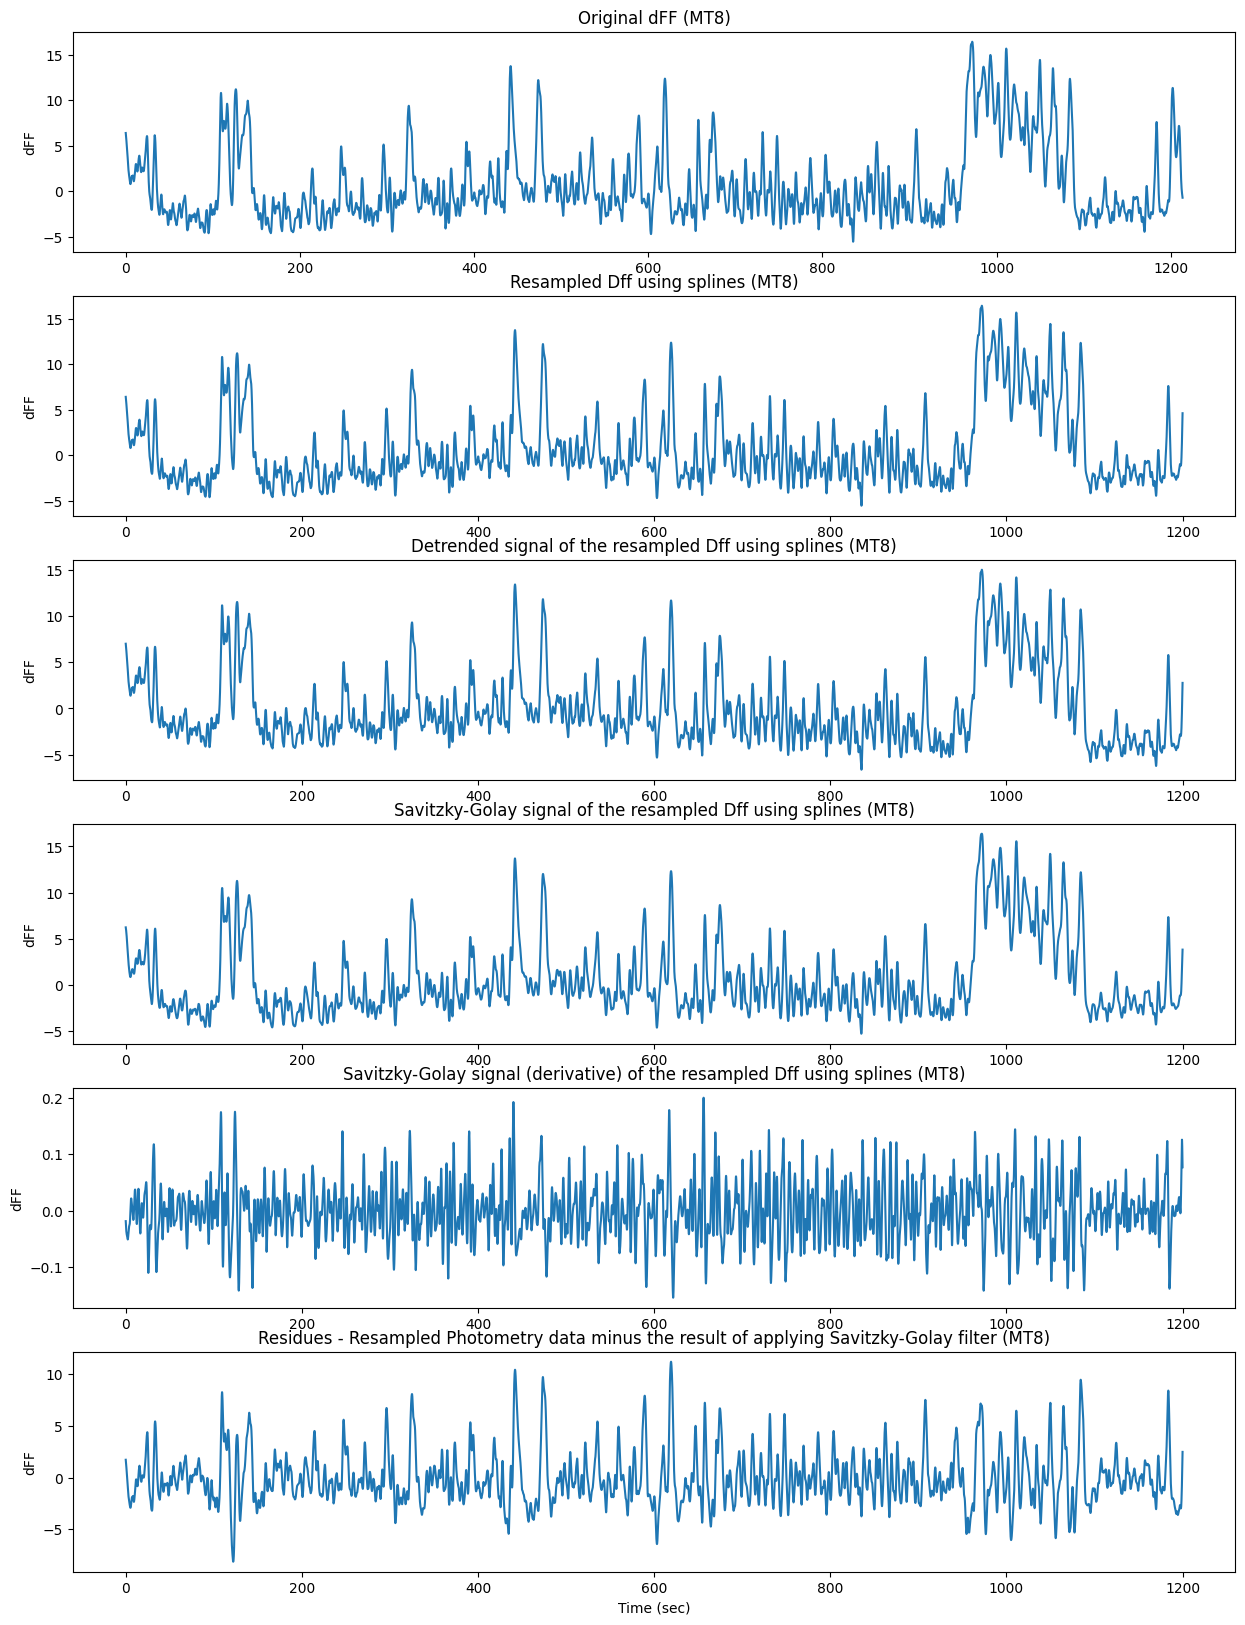

In [ ]:
which_col=9
plt.figure(figsize = (15, 20))
plt.subplot(6,1,1)
plt.plot(dFF_traces[cols[0]],dFF_traces[cols[which_col]])
#plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Original dFF ({cols[which_col]})")
plt.subplot(6,1,2)
plt.plot(new_dFF_traces[cols[0]],new_dFF_traces[cols[which_col]])
#plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Resampled Dff using splines ({cols[which_col]})")
plt.subplot(6,1,3)
plt.plot(new_dFF_traces_det[cols[0]],new_dFF_traces_det[cols[which_col]])
#plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Detrended signal of the resampled Dff using splines ({cols[which_col]})")
plt.subplot(6,1,4)
plt.plot(new_dFF_traces_sg[cols[0]],new_dFF_traces_sg[cols[which_col]])
#plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Savitzky-Golay signal of the resampled Dff using splines ({cols[which_col]})")
plt.subplot(6,1,5)
plt.plot(new_dFF_traces_sg_der[cols[0]],new_dFF_traces_sg_der[cols[which_col]])
#plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Savitzky-Golay signal (derivative) of the resampled Dff using splines ({cols[which_col]})")
plt.subplot(6,1,6)
plt.plot(new_dFF_traces_sg_fl[cols[0]],new_dFF_traces_sg_fl[cols[which_col]])
plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"Residues - Resampled Photometry data minus the result of applying Savitzky-Golay filter ({cols[which_col]})")
plt.show()

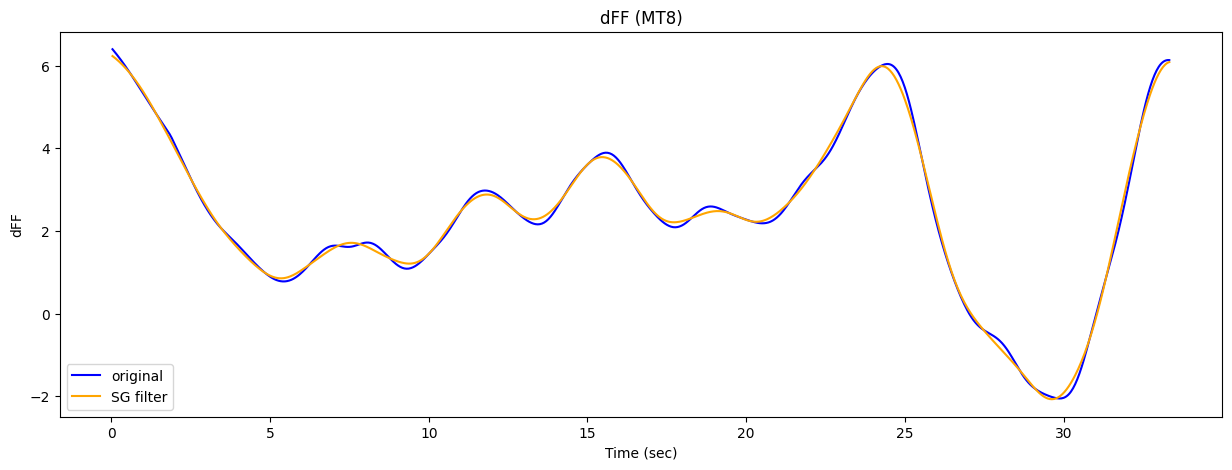

In [ ]:
which_col=9
leng=1000
plt.figure(figsize = (15, 5))
plt.plot(new_dFF_traces[cols[0]][:leng],new_dFF_traces[cols[which_col]][:leng],color="blue",label="original")
plt.xlabel("Time (sec)")
plt.ylabel("dFF")
plt.title(f"dFF ({cols[which_col]})")
plt.plot(new_dFF_traces_sg[cols[0]][:leng],new_dFF_traces_sg[cols[which_col]][:leng],color="orange",label="SG filter")
plt.legend()
plt.show()

In [ ]:
new_dFF_traces.to_csv(path+'Photometry_DeltaF_traces_int.csv', sep=',', index=False, encoding='utf-8')
new_dFF_traces_der.to_csv(path+'Photometry_DeltaF_traces_der.csv', sep=',', index=False, encoding='utf-8')
new_dFF_traces_det.to_csv(path+'Photometry_DeltaF_traces_det.csv', sep=',', index=False, encoding='utf-8')
new_dFF_traces_sg.to_csv(path+'Photometry_DeltaF_traces_sg.csv', sep=',', index=False, encoding='utf-8')
new_dFF_traces_sg_der.to_csv(path+'Photometry_DeltaF_traces_sg_der.csv', sep=',', index=False, encoding='utf-8')
new_dFF_traces_sg_fl.to_csv(path+'Photometry_DeltaF_traces_sg_fl.csv', sep=',', index=False, encoding='utf-8')

# Now separate the photometry and movement data for each animal and save the result to csv files

Check if the path is correct.

In [ ]:
path

'/content/drive/MyDrive/Dados/Flavitcho/'

Create new columns following SP1_data_extinction.csv

In [ ]:
new_cols=["Times","Ff","Movement","Freezing"]
display(new_cols)

['Times', 'Ff', 'Movement', 'Freezing']

## Save csv files - syncronized files - no pre-processing of the photometry data

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces['Time']
    SP[new_cols[1]]=new_dFF_traces[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')


## Save csv files - syncronized files - derivative of the photometry data

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_der['Time']
    SP[new_cols[1]]=new_dFF_traces_der[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_der.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')

## Save csv files - syncronized files - Detrended photometry data

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_det['Time']
    SP[new_cols[1]]=new_dFF_traces_det[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_det.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')

## Save csv files - syncronized files - photometry data after going through Savitzky-Golay filter

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_sg['Time']
    SP[new_cols[1]]=new_dFF_traces_sg[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_sg.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')

## Save csv files - syncronized files - derivative of photometry data after going through Savitzky-Golay filter

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_sg_der['Time']
    SP[new_cols[1]]=new_dFF_traces_sg_der[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_sg_der.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')

## Save csv files - syncronized files - photometry data folllwing Flavitcho's idea.

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_sg_fl['Time']
    SP[new_cols[1]]=new_dFF_traces_sg_fl[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_sg_fl.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')

## Save csv files - syncronized files - normalization the photometry data using zcores

In [ ]:
SP = pd.DataFrame(columns=new_cols)
for name_cols in cols[1:]:
    SP[new_cols[0]]=new_dFF_traces_zs['Time']
    SP[new_cols[1]]=new_dFF_traces_zs[name_cols]
    SP[new_cols[2]]=activity[name_cols]
    SP[new_cols[3]]=freezing[name_cols]
    s = path + f"{name_cols}_data_extinction_zs.csv"
    SP.to_csv(s, sep=',', index=False, encoding='utf-8')